In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import time
from queue import heappush, heappop

sns.set()
sns.set_style("whitegrid")
color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline

## Loading images from four-shapes kaggle dataset

In [2]:
import imageio
import os
from PIL import Image
from IPython.display import clear_output

four_shapes_dir = "./datasets/four_shapes/shapes"

def get_images(cnt, step=1, shape='triangle', start=600, size=10, normalized=True):
    cnt = int(cnt) # if cnt is float
    if not isinstance(size, tuple):
        size = (size, size)
    
    images = []        
    for i in range(cnt):
        ind = start + i * step
        img_path = os.path.join(four_shapes_dir, shape, f"{ind}.png")
        img = imageio.imread(img_path)
        resized_img = Image.fromarray(img).resize(size)
        img_arr = np.array(resized_img, dtype=np.float16) / 255. if normalized else np.array(resized_img)
        images.append(img_arr)
    return images

def slideshow_images(images, delay=.2):
    for img in images:
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(delay)

# get_images(2, size=6)[0]
# slideshow_images(get_images(30, step=4, size=32, normalized=False, shape='triangle'))

## Helpers

In [4]:
def make_md_list(fn_elem_init, *args):
    if len(args) == 0:
        return fn_elem_init()
    return [make_md_list(fn_elem_init, *args[1:]) for _ in range(args[0])]

def iterate_flatten_dims(a, dims):
    return a if dims < 1 else (
        x
        for sub_a in a
        for x in iterate_flatten_dims(sub_a, dims - 1)
    )

t = make_md_list(list, 3, 2, 1)
print(t)
print([x for x in iterate_flatten_dims(t, 2)])

[[[[]], [[]]], [[[]], [[]]], [[[]], [[]]]]
[[], [], [], [], [], []]


In [9]:
def get_expected_spike_count():
    mean_fire_rate = np.mean(np.array(images))*white_rate + black_rate
    return mean_fire_rate * t_end * width * height

def get_expected_event_count():
    return n_frames * width * height

## Common methods

In [78]:
from math import floor, ceil

def get_time():
    return time.thread_time()

def scaled_time(T0, T):
    return (T - T0) / unit_of_time

def sample_spike_dt(t, rate):
    scale = 1./rate
    return np.random.exponential(scale=scale) + .003 * scale

def recalculate_neuron_state(ind, t, is_spike, is_intensity_based):
    rate = rate_lambda_intensity_based(t, ind) if is_intensity_based else rate_lambda_diff_based(t, ind)
    save_events(ind, t, rate, is_spike)
    
    next_spike_dt = sample_spike_dt(t, rate)
    next_spike_t = t + min(next_spike_dt, max_no_fire_dt)
    will_spike = next_spike_dt < max_no_fire_dt

    return next_spike_t, will_spike

def get_frame_ind(t):
    return min(floor(t / frame_dt), n_frames - 1)

def rate_lambda_intensity_based(t, ind):
    i, j = ind
    frame_ind = get_frame_ind(t)
    pixel = images[frame_ind][i][j]
    return black_rate + white_rate * pixel

def rate_lambda_diff_based(t, ind):
    i, j, is_pos = ind
    frame_ind = get_frame_ind(t)
    prev_frame_ind = max(frame_ind - 1, 0)
    pixel_diff = images[frame_ind][i][j] - images[prev_frame_ind][i][j]
    
    if (pixel_diff > pixel_diff_eps and is_pos) or (pixel_diff < -pixel_diff_eps and not is_pos):
        return black_rate + white_rate * abs(pixel_diff)
    else:
        return black_rate

def save_events(ind, t, rate, is_spike):
    t_ts, t_rates, t_spikes = ts, rates, spikes
    for i in ind:
        t_ts, t_rates, t_spikes = t_ts[i], t_rates[i], t_spikes[i]
    
    t_ts.append(t)
    t_rates.append(rate)
    if is_spike:
        t_spikes.append(t)

## Intensity based

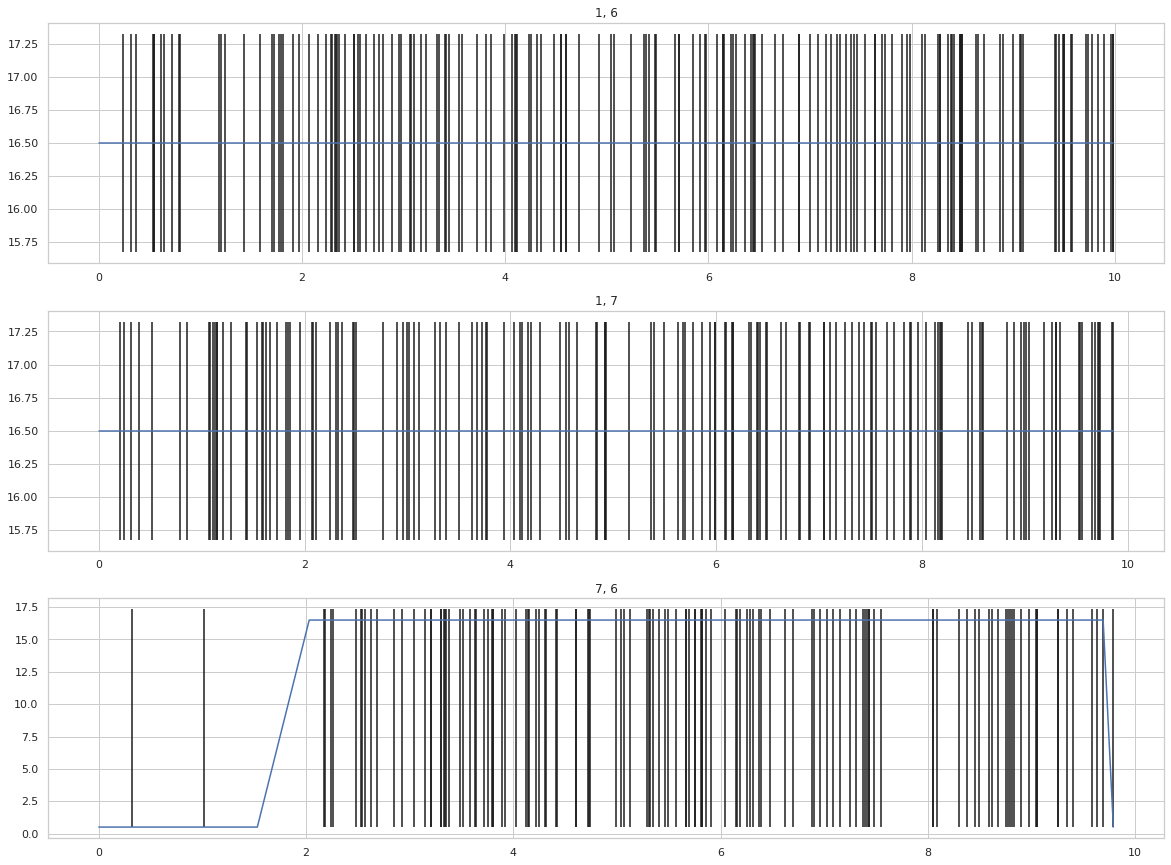

CPU times: user 1.98 s, sys: 11.9 ms, total: 1.99 s
Wall time: 2 s


(410521, 56617, 55829, 58656.25, 4.427377194579201e-05)

In [24]:
%%time

unit_of_time = .1   # fraction of second
fpu = 4. # frames per unit of time
t, t_end = 0., 10.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, 16.
width, height = 20, 20
images = get_images(n_frames, step=2, shape='star', size=(width, height))
T0 = get_time()
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 2

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height) for _ in range(3)]
for i in range(width):
    for j in range(height):
        ind = (i, j)
        next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike=False, is_intensity_based=True)
        heappush(pq_times, (next_spike_t, is_spike, ind))

free_spin_count, lag = 0, 0.
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, get_time())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    lag += t - next_spike_t
    heappop(pq_times)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike, is_intensity_based=True)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    x, y = np.random.randint(0, width, size=(2,))
    sns.lineplot(ts[x][y], rates[x][y], ax=ax)

    min_rates, max_rates = min(rates[x][y]), max(rates[x][y])
    ax.vlines(spikes[x][y], min_rates * .95, max_rates * 1.05)
    ax.set_title(f"{x}, {y}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 1))) - width * height
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 1)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent

## Multiple neurons, difference based intensity

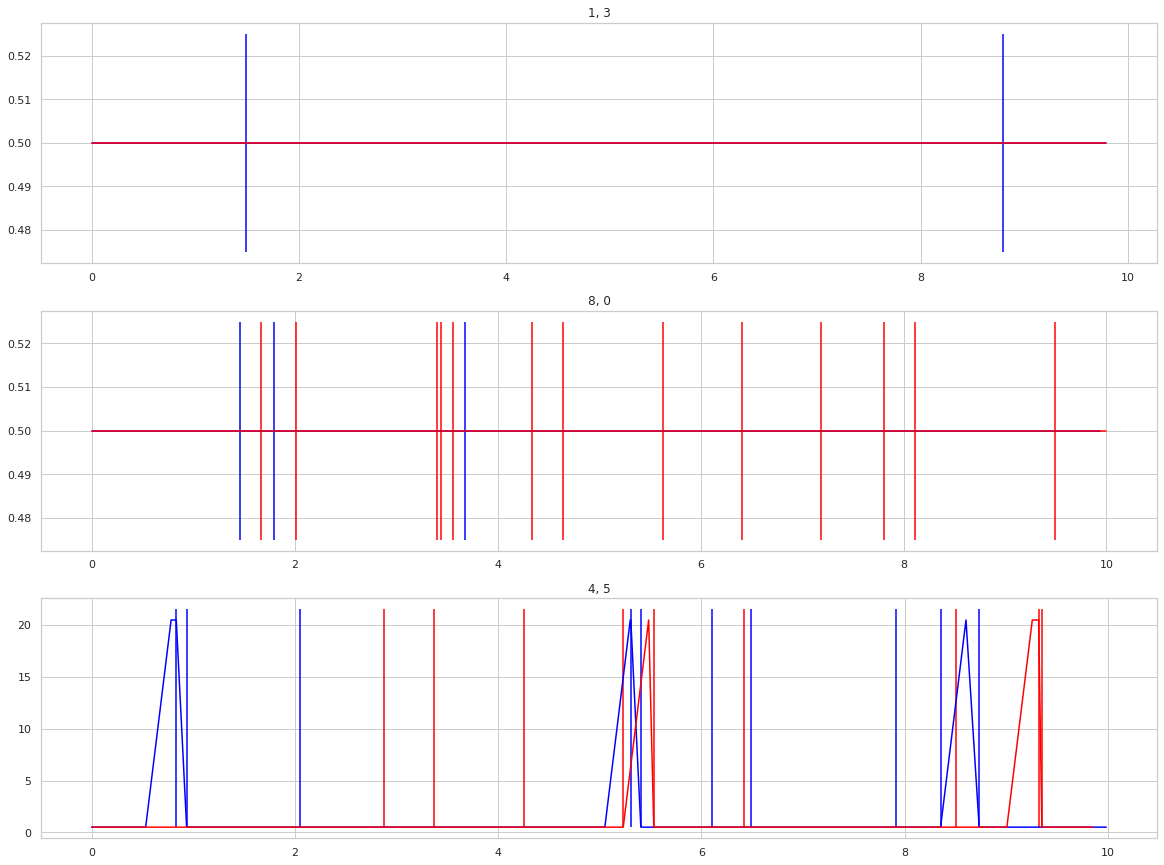

CPU times: user 1.56 s, sys: 12 ms, total: 1.57 s
Wall time: 1.57 s


(392809, 22139, 2964, 46355.0, 0.00028955044049256345)

In [43]:
%%time

unit_of_time = .05   # fraction of second
fpu = 6. # frames per unit of time
t, t_end = 0., 10.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, fpu * 3
width, height = 16, 16
images = get_images(n_frames, step=int(24./fpu), shape='star', size=(width, height))
T0 = get_time()
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 1.5
pixel_diff_eps = 1./256

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height, 2) for _ in range(3)]
for i in range(width):
    for j in range(height):
        for is_pos in [False, True]:
            ind = (i, j, is_pos)
            next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike=False, is_intensity_based=False)
            heappush(pq_times, (next_spike_t, is_spike, ind))

free_spin_count = 0
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, get_time())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    heappop(pq_times)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike, is_intensity_based=False)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    x, y = np.random.randint(0, width, size=(2,))
    min_rates, max_rates = min(min(rates[x][y])), max(max(rates[x][y]))
    for z, color in enumerate(['blue', 'red']):
        sns.lineplot(np.array(ts[x][y][z]), np.array(rates[x][y][z]), ax=ax, color=color)        
        ax.vlines(spikes[x][y][z], min_rates * .95, max_rates * 1.05, colors=color)

    ax.set_title(f"{x}, {y}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 2)))
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 2)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent

## With second layer

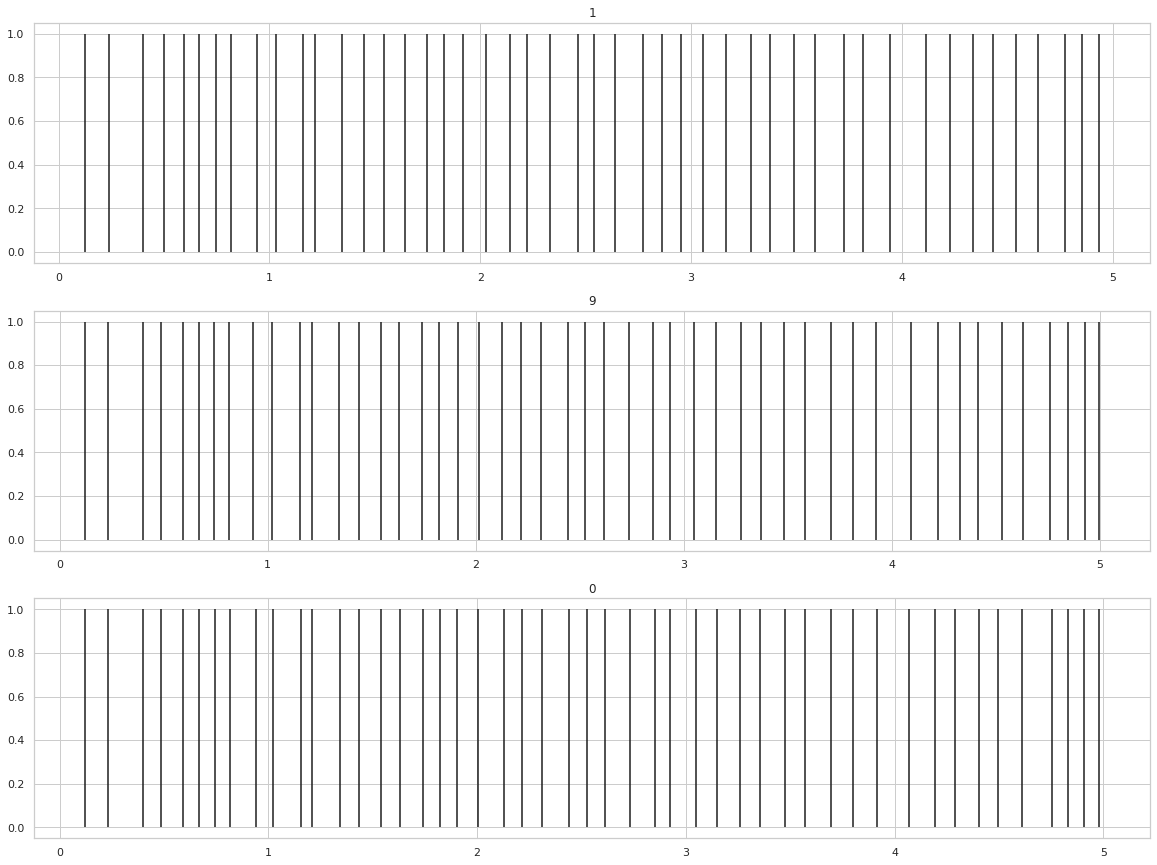

CPU times: user 1.13 s, sys: 20 ms, total: 1.15 s
Wall time: 1.16 s


(53434, 11027, 1468, 21036.25, 0.0005835733969048691)

In [140]:
%%time

unit_of_time = .05   # fraction of second
fpu = 6. # frames per unit of time
t, t_end = 0., 5.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, fpu * 3
width, height = 16, 16
images = get_images(n_frames, step=int(24./fpu), shape='star', size=(width, height))
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 1.5
pixel_diff_eps = 1./256

n_hidden_neurons = 10
hid_rate = .2
base_potential = -30.
hid_potentials = np.full(n_hidden_neurons, base_potential, dtype=np.float16)
hid_spikes = make_md_list(list, n_hidden_neurons)

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height, 2) for _ in range(3)]
for i in range(width):
    for j in range(height):
        for is_pos in [False, True]:
            ind = (i, j, is_pos)
            next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike=False, is_intensity_based=False)
            heappush(pq_times, (next_spike_t, is_spike, ind))

def propagate_spike(ind, t):
    global hid_potentials
    hid_potentials = hid_potentials + np.random.normal(loc=1., scale=.1, size=hid_potentials.shape)
    for i, p in enumerate(hid_potentials):
        if p >= 0:
            hid_spikes[i].append(t)
            hid_potentials[i] = base_potential
            
T0 = get_time()            
free_spin_count = 0
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, get_time())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    heappop(pq_times)
    if is_spike:
        propagate_spike(ind, t)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike, is_intensity_based=False)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax in axes:
    i = np.random.randint(0, n_hidden_neurons)
    ax.vlines(hid_spikes[i], 0, 1)
    ax.set_title(f"{i}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 2)))
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 2)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent

## Output neuron

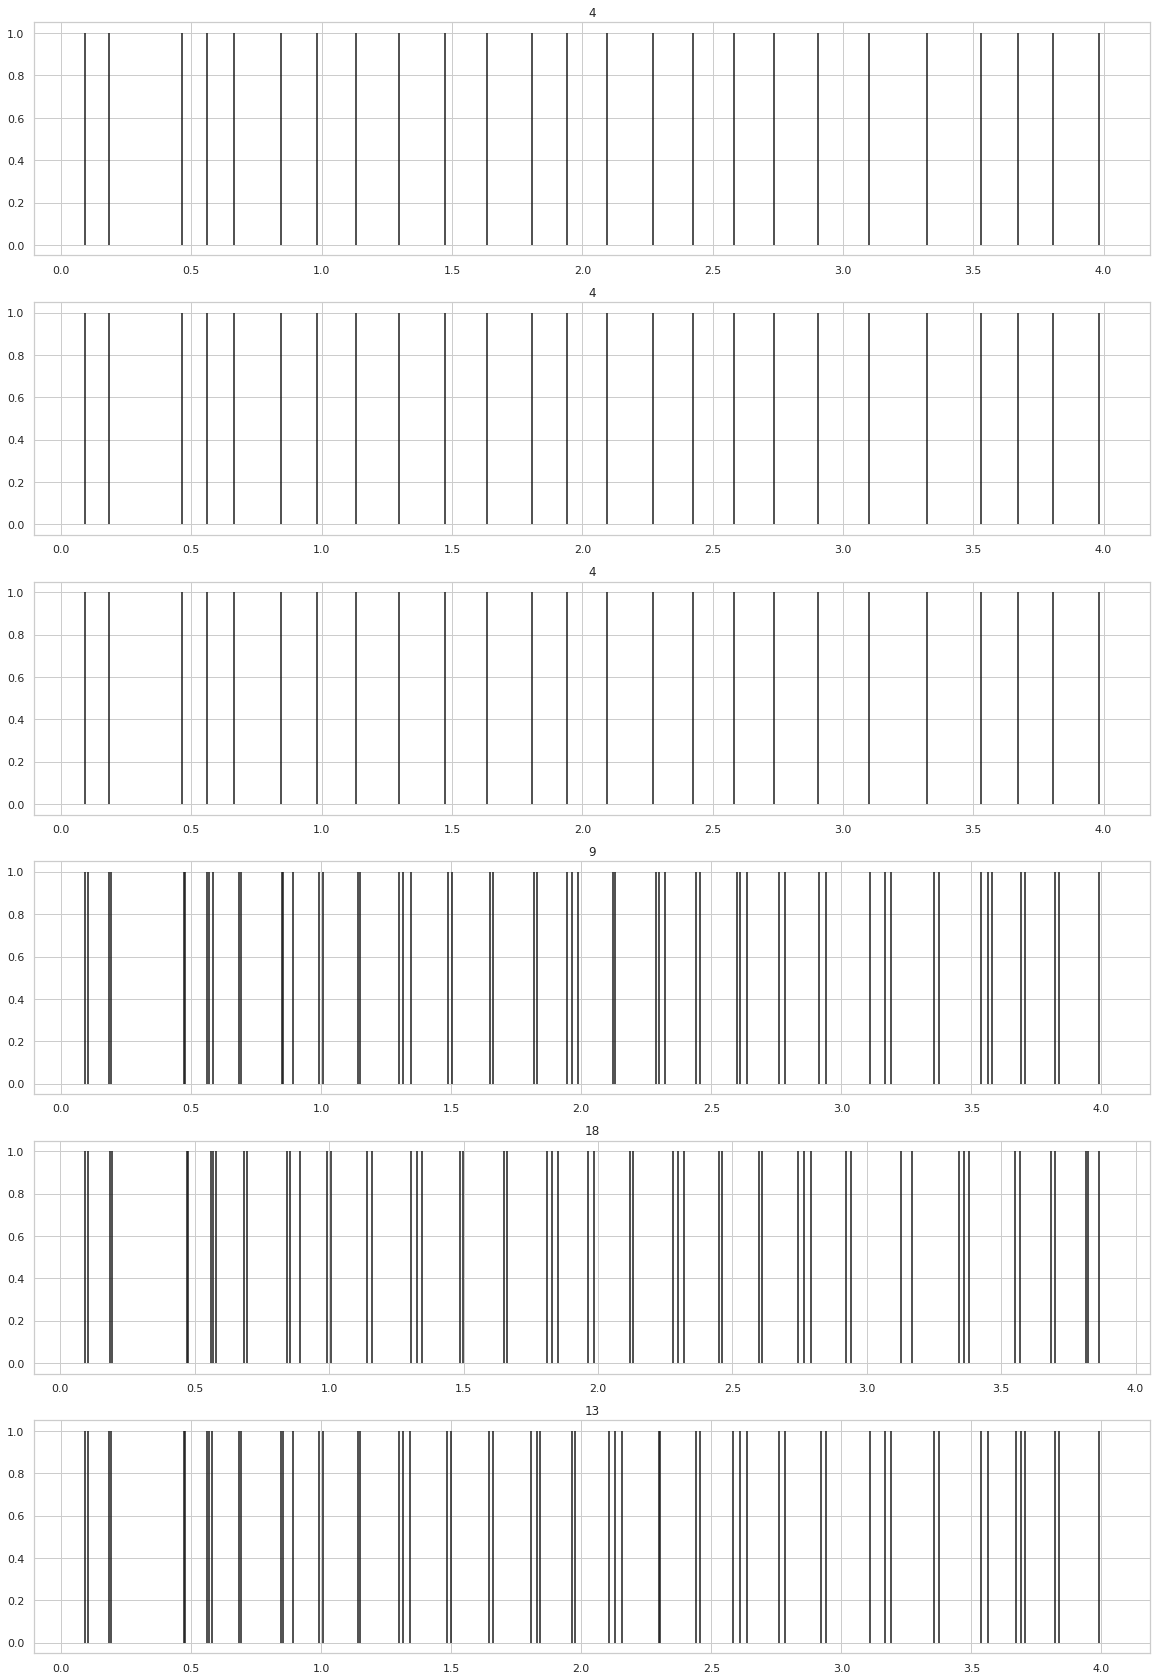

CPU times: user 2.33 s, sys: 7.94 ms, total: 2.33 s
Wall time: 2.33 s


(1069, 8328, 1010, 26281.25, 0.0008185001980317201)

In [167]:
%%time

unit_of_time = .05   # fraction of second
fpu = 6. # frames per unit of time
t, t_end = 0., 4.
n_frames = int(fpu * t_end)
black_rate, white_rate = .5, fpu * 3
width, height = 20, 20
images = get_images(n_frames, step=int(24./fpu), shape='star', size=(width, height))
frame_dt = t_end / n_frames
max_no_fire_dt = frame_dt * 1.5
pixel_diff_eps = 1./256

n_hidden_neurons = 20
hid_rate = .2
hid_base_potential = -40.
hid_potentials = np.full(n_hidden_neurons, hid_base_potential, dtype=np.float16)
hid_spikes = make_md_list(list, n_hidden_neurons)

n_output_neurons = 20
out_base_potential = -8.
out_potentials = np.full(n_output_neurons, out_base_potential, dtype=np.float16)
out_spikes = make_md_list(list, n_output_neurons)

pq_times = []
ts, rates, spikes = [make_md_list(list, width, height, 2) for _ in range(3)]
for i in range(width):
    for j in range(height):
        for is_pos in [False, True]:
            ind = (i, j, is_pos)
            next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike=False, is_intensity_based=False)
            heappush(pq_times, (next_spike_t, is_spike, ind))

def propagate_spike_to_hidden(ind, t):
    global hid_potentials
    hid_potentials += np.random.normal(loc=1., scale=.1, size=hid_potentials.shape)
    for i, p in enumerate(hid_potentials):
        if p >= 0:
            hid_spikes[i].append(t)
            hid_potentials[i] = hid_base_potential
            propagate_spike_to_output(ind, t)
            
def propagate_spike_to_output(ind, t):
    global out_potentials
    out_potentials += np.random.normal(loc=1., scale=.1, size=out_potentials.shape)
    for i, p in enumerate(out_potentials):
        if p >= 0:
            out_spikes[i].append(t)
            out_potentials[i] = out_base_potential
            
T0 = get_time()            
free_spin_count = 0
next_spike_t, is_spike, ind = pq_times[0]
while t <= t_end:
    t = scaled_time(T0, get_time())
    if t < next_spike_t:
        free_spin_count += 1
        continue
    
    heappop(pq_times)
    if is_spike:
        propagate_spike_to_hidden(ind, t)
    next_spike_t, is_spike = recalculate_neuron_state(ind, t, is_spike, is_intensity_based=False)
    heappush(pq_times, (next_spike_t, is_spike, ind))
    
    next_spike_t, is_spike, ind = pq_times[0]

fig, axes = plt.subplots(6, 1, figsize=(20, 30))

for ax in axes[:3]:
    i = np.random.randint(0, n_hidden_neurons)
    ax.vlines(hid_spikes[i], 0, 1)
    ax.set_title(f"{i}")

for ax in axes[-3:]:
    i = np.random.randint(0, n_output_neurons)
    ax.vlines(out_spikes[i], 0, 1)
    ax.set_title(f"{i}")

plt.show()
event_count = sum(map(len, iterate_flatten_dims(ts, 2)))
spikes_count = sum(map(len, iterate_flatten_dims(spikes, 2)))
lag_percent = 100 * (lag / event_count) / (event_count / t_end)
free_spin_count, event_count, spikes_count, get_expected_spike_count(), lag_percent